# Import des librairies

In [91]:
import pandas as pd
# output option format of pandas library changed (to not have exponentials)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np

pd.options.display.max_columns = None # pour afficher toutes les colonnes
pd.options.display.max_rows = None # pour afficher toutes les lignes

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf

from functions import *
from functions2 import *

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster, centroid


import statsmodels.formula.api as smf
import statsmodels.api as sm

# Import du dataset

In [92]:
billets2 = pd.read_csv('billets2.csv')

In [166]:
billets2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,Clusters_KMeans
0,1,171.81000,104.86000,104.95000,4.52000,2.89000,112.83000,0
1,1,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000,0
2,1,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000,0
3,1,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000,0
4,1,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000,0


# ACP

## Préparation des données et éboulis de valeurs propres

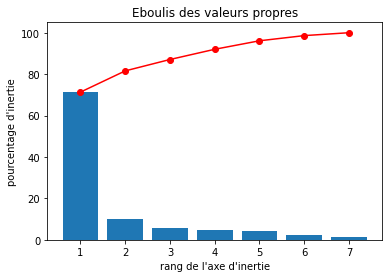

None
Pourcentages d'inertie par axe : 
 [71.312555   10.2525804   5.50020789  4.93187076  4.10654269  2.49960448
  1.39663876]


In [94]:
# choix du nombre de composantes à calculer (le nombre de variables)
n_comp = 7


# Comme objet array ne peut pas garder en mémoire nom des colonnes, on les sauvegarde dans variables
features = billets2.columns

# # conversion du dataframe en type numpy.array
data_pca = billets2
X = data_pca.values
X

# On donne le nb de composants à calculer
pca = decomposition.PCA(n_components=n_comp)
# Calcul proprement dit
pca.fit(X)

# Eboulis des valeurs propres
print(display_scree_plot(pca))
# Pourcentages d'inertie par axe
np.set_printoptions(suppress=True)
print('Pourcentages d\'inertie par axe :','\n',pca.explained_variance_ratio_*100)

Les 2 premiers axes d'inertie capturent environ 80% de l'inertie.

In [95]:
# Pourcentage de variance expliquée cumulée
expl_var_ratio = pd.DataFrame(pca.explained_variance_ratio_*100)
expl_var_ratio.cumsum()

,0
0,71.31255
1,81.56514
2,87.06534
3,91.99721
4,96.10376
5,98.60336
6,100.00000


### Analyse du nombre de composantes à prendre en compte

Selon le critère de Kaiser, on ne prend pas en compte les axes dont l'inertie est inférieure à 100/p (où p = nombre de variables) car moins de variabilité qu'une seule variable initiale.
Comme 100/7 = 14.28, on doit s'arrêter à 1 axe maximum.

## Contribution des variables aux composantes principales

### Cercle des corrélations F1-F2

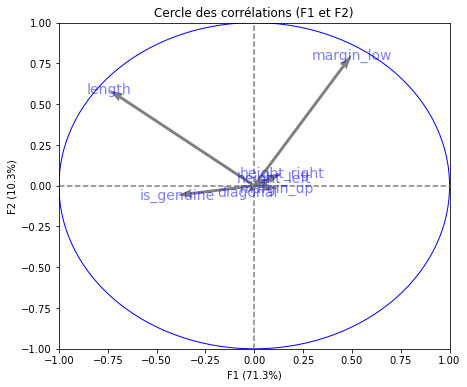

In [96]:
# récupération du calcul des composantes dans nouvelle variable
pcs = pca.components_

# Transmission à la fonction display_circles du calcul des composantes, du nb de composantes..
# ..de l'objet pca, les plans facoriels souhaités et le nom des individus
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

### Analyse de la composition linéaire des axes d'inertie
    

### combinaison linéaire de F1

In [97]:
# Extraction des coefficients de corrélation des variables à F1
F = pca.components_[0]
# Ajout du nom des variables
F = pd.DataFrame(F,index=features, columns=['coefficient'])
F.sort_values(by='coefficient',ascending=False)

,coefficient
margin_low,0.49856
height_right,0.14036
margin_up,0.11850
height_left,0.10209
diagonal,-0.03314
is_genuine,-0.39233
length,-0.74314


### <a name="C8252">combinaison linéaire de F2

In [98]:
# Extraction des coefficients de corrélation des variables à F2
F = pca.components_[1]
# Ajout du nom des variables
F = pd.DataFrame(F,index=features, columns=['coefficient'])
F.sort_values(by='coefficient',ascending=False)

,coefficient
margin_low,0.80069
length,0.58777
height_right,0.07652
height_left,0.04607
margin_up,-0.01692
diagonal,-0.04234
is_genuine,-0.05801


## <a name="C83">Projection des individus

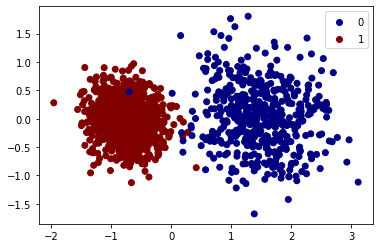

In [99]:
# Affichage des individus par projection des individus sur F1 et F2
pca = decomposition.PCA(n_components=7).fit(X)
X_projected = pca.transform(X)

scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], cmap = 'jet', alpha=1, c=billets2['is_genuine'])

plt.legend(*scatter.legend_elements())

### <a name="C831"> Analyse de la contribution de chaque individu aux axes

In [172]:
# Contributions aux axes afin de détecter d'éventuelles valeurs extrêmes fuassant l'analyse
# Calcul : carré de la distance à l'origine pour chaque individu sur chaque axe..
# ..divisé par la variance de l'axe (eigenvalue - valeurs propres) * nombre d'individus

# Calcul des valeurs propres
eigval = ((1500-1)/1500)*pca.explained_variance_

ctr = X_projected**2 # carré de la distance à l'origine pour chaque individu sur chaque axe
for row in range(7):
 ctr[:,row] = ctr[:,row]/(1500*eigval[row])# division par la variance de l'axe*nombre d'individus

axe_contribution = pd.DataFrame({'id':billets2.index,'CTR_1':ctr[:,0]})

In [101]:
#vérification (somme des contributions aux axes est censé être égal à 0)
print(np.sum(ctr,axis=0))

[1. 1. 1. 1. 1. 1. 1.]


Pour se donner un ordre d'idée, si la contribution était égalitaire entre les individus, elle devrait être à 1/1500=0.000667 soit 0.067%.

#### <a name="C8311">Contribution à F1

In [173]:
axe_contribution.sort_values(by='CTR_1',ascending=False).head(10)

,id,CTR_1
1052,1052,0.00516
1320,1320,0.00467
1416,1416,0.00455
1497,1497,0.00407
1093,1093,0.00388
1251,1251,0.00382
1028,1028,0.00369
1277,1277,0.00367
1058,1058,0.00356
1194,1194,0.00356


# <a name="C96">K Means

In [103]:
# Nombre de clusters souhaités
n_clust = 2
# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)
# Récupération des clusters attribués à chaque individu
clusters = km.labels_
# Ajout des N° de cluster
billets2['Clusters_KMeans'] = clusters

### <a name="C98">Nombre de pays par cluster

In [104]:
billets2.value_counts('Clusters_KMeans')

Clusters_KMeans
0    1009
1     491
dtype: int64

### <a name="C99">Affichage des clusters sur les plans factoriels

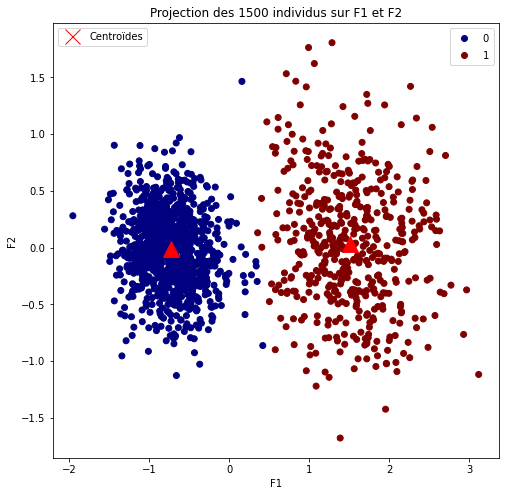

In [105]:
# Affichage du clustering par projection des individus sur F1 et F2
pca = decomposition.PCA(n_components=7).fit(X)
X_projected = pca.transform(X)
# Scatterplot des clusters
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], c=billets2['Clusters_KMeans'], cmap = 'jet', alpha=1)
# Titre du graphe
plt.title("Projection des {} individus sur F1 et F2".format(X_projected.shape[0]))
# Légende pour les clusters
first_legend = plt.legend(*scatter.legend_elements(),loc=1) # initialisation
ax = plt.gca().add_artist(first_legend) # affichage
# titre des axes
plt.xlabel('F1')
plt.ylabel('F2')
# Taille du graphe
fig = plt.gcf()
fig.set_size_inches(8,8)
# Scatterplot des centroïdes
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1], marker = '^', color='red', s=250)
# Légénde pour les centroïdes
second_legend = [Line2D([0], [0], marker='x', color='red', label='Centroïdes',markersize=15,ls='')] # intitialisation
plt.legend(handles=second_legend, loc=2) # affichage

plt.show(block=False)

### <a name="C100">Moyenne des variables par cluster

In [106]:
temp_df = pd.pivot_table(billets2,
                         values=billets2.columns,
                         aggfunc='mean',
                         index='Clusters_KMeans')
temp_df

,diagonal,height_left,height_right,is_genuine,length,margin_low,margin_up
Clusters_KMeans,,,,,,,
0,171.98680,103.95060,103.81134,0.99108,113.19945,4.11993,3.05482
1,171.90016,104.19173,104.14424,0.00000,111.60794,5.22959,3.35010


## Matrice de confusion

In [107]:
contingency_matrix = pd.crosstab(billets2['Clusters_KMeans'], billets2['is_genuine'])

print(contingency_matrix)


is_genuine         0     1
Clusters_KMeans           
0                  9  1000
1                491     0


9 faux négaitfs : billets considérés comme vrais par le partitionnement K Means. Par contre, le modèle a repéré tous les vrais billets.

In [108]:
#Accuracy
100-(9/1500*100)

99.4

0.6% d'erreurs.

In [109]:
# Taux de faux négatifs : faux négatifs sur faux billets
9/500*100

1.7999999999999998

# Régression logistique

## préparation des datasets

### Préparation datasets avec variable expliquée séparée des variables exlicatives

In [110]:
# Splitting Data into Training and Test Sets (test_set = 25%)


x_train, x_test, y_train, y_test = train_test_split(billets2[['diagonal','height_left','height_right',\
                                                             'length','margin_low','margin_up']],\
                                                    billets2['is_genuine'], test_size=0.25, random_state=0)

In [111]:
# Séparation sur tout le daset variables explicatives - variable expliquée
x_billets2 = billets2[['diagonal','height_left','height_right','length','margin_low','margin_up']]
y_billets2 = billets2['is_genuine']

In [112]:
# Vérification
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))
print(len(x_billets2))
print(len(y_billets2))

1125
1125
375
375
1500
1500


### Préparation des datasets sans séparation variable expliquée variables explicatives

In [113]:
# (test_set = 25%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(billets2,test_size=0.25, random_state=0)

In [114]:
# Vérification
print(len(train))
print(len(test))

1125
375


# Régression logistique avec statsmodels (toutes variables)

## Calcul de la régression logistique

In [115]:
# building the model and fitting the data
log_reg = smf.logit("is_genuine ~ diagonal + height_left + height_right +\
                    margin_low + margin_up + length", data=train).fit()

Optimization terminated successfully.
         Current function value: 0.024076
         Iterations 13


In [116]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1118
Method:                           MLE   Df Model:                            6
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.9619
Time:                        08:38:35   Log-Likelihood:                -27.086
converged:                       True   LL-Null:                       -711.13
Covariance Type:            nonrobust   LLR p-value:                1.970e-292
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -208.4676    295.978     -0.704      0.481    -788.573     371.638
diagonal         1.2496      1.375      0.909      0.364      -1.446       3.945
height_left     -1.8153      1.402     -1.29

## Résultat sur le test set

In [117]:
# performing predictions on the test datdaset
yhat = log_reg.predict(test)
prediction = list(map(round, yhat))

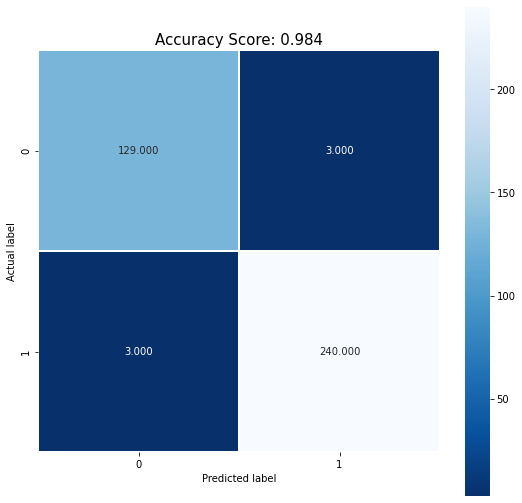

In [118]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_test, prediction)

# accuracy score of the model
accuracy_score = accuracy_score(y_test, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [119]:
# Taux de faux billets non détectés
3/132*100

2.272727272727273

## Résultat sur le train set

In [120]:
# performing predictions on the test datdaset
yhat = log_reg.predict(train)
prediction = list(map(round, yhat))
len(prediction)

1125

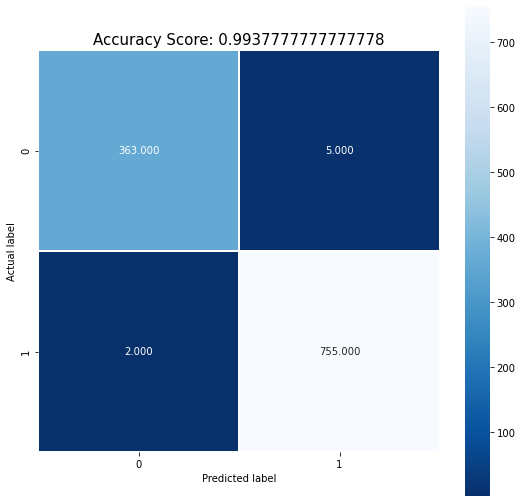

In [121]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_train, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_train, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [122]:
# Taux de faux billets non détectés
5/368*100

1.358695652173913

## Résultat sur tout le dataset

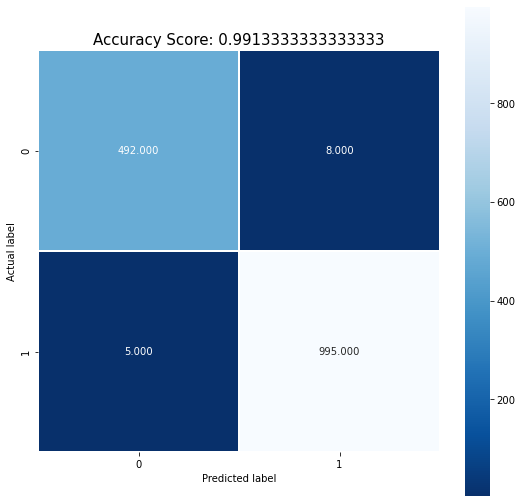

In [123]:
# performing predictions on the test datdaset
yhat = log_reg.predict(billets2)
prediction = list(map(round, yhat))

# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_billets2, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_billets2, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [124]:
# taux de faux négatifs : 
8/500*100

1.6

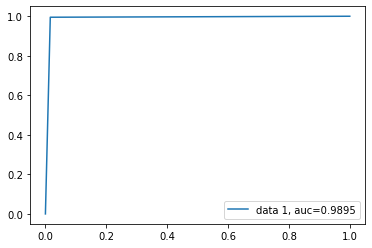

In [125]:
# ROC Curve
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = billets2['is_genuine']
y_probas = prediction

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Régression logistique avec statsmodels
- intercept (constante) enlevé du modèle : p value à 0.481

In [126]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.024297
         Iterations 12


In [127]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1119
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.9616
Time:                        08:38:36   Log-Likelihood:                -27.334
converged:                       True   LL-Null:                       -711.13
Covariance Type:            nonrobust   LLR p-value:                1.452e-293
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
diagonal         0.5191      0.892      0.582      0.561      -1.229       2.267
height_left     -2.1064      1.326     -1.589      0.112      -4.705       0.492
height_right    -3.9167      1.390     -2.81

## Résultat sur le test set

In [128]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_test)
prediction = list(map(round, yhat))

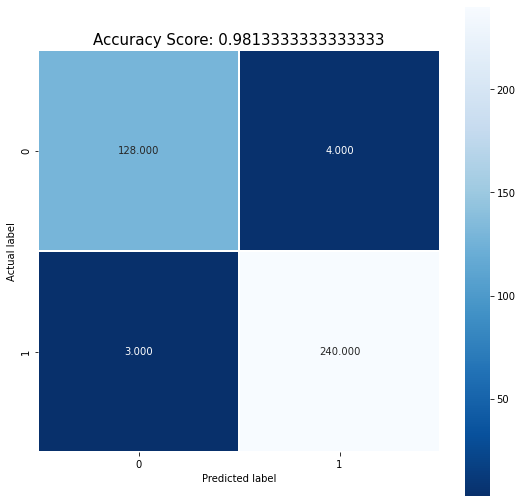

In [129]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_test, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_test, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [130]:
# Taux de faux billets non détectés
4/132*100

3.0303030303030303

## Résultat sur le train set

In [131]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_train)
prediction = list(map(round, yhat))

In [132]:
len(prediction)

1125

In [133]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_train, prediction) 
print ("Confusion Matrix : \n", cm)

# accuracy score of the model
accuracy_score = accuracy_score(y_train, prediction)
print('Test accuracy = ', accuracy_score)

Confusion Matrix : 
 [[363   5]
 [  2 755]]
Test accuracy =  0.9937777777777778


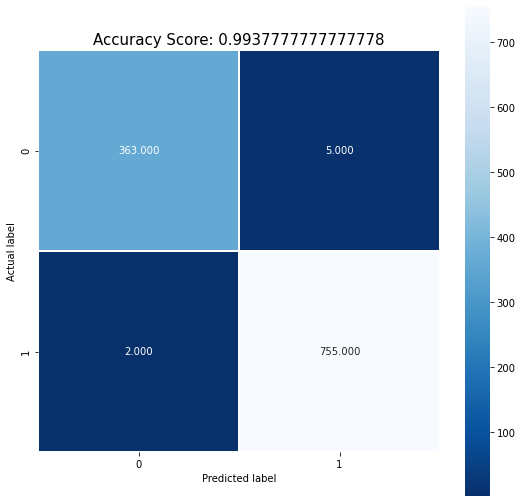

In [134]:
# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [135]:
# Taux de faux billets non détectés
5/368*100

1.358695652173913

## Résultat sur tout le dataset

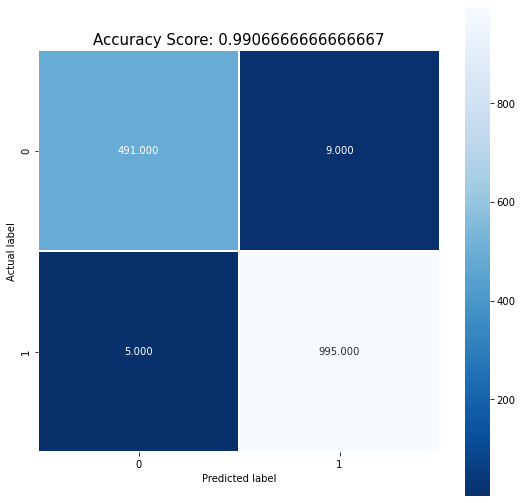

In [136]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_billets2)
prediction = list(map(round, yhat))

# confusion matrix

from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_billets2, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_billets2, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [137]:
# taux de faux négatifs : 
9/500*100

1.7999999999999998

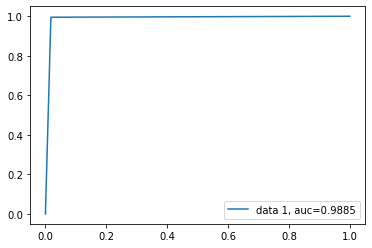

In [138]:
# ROC Curve
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = billets2['is_genuine']
y_probas = prediction

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Régression logistique avec statsmodels
- diagonal enlevé du modèle : p value à 0.561

## Suppression colonne diagonal

In [139]:
x_train = x_train.drop(columns='diagonal')
x_test = x_test.drop(columns='diagonal')
x_billets2 = x_billets2.drop(columns='diagonal')

## Calcul de la régression logistique

In [140]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.024450
         Iterations 12


In [141]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1120
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.9613
Time:                        08:38:37   Log-Likelihood:                -27.506
converged:                       True   LL-Null:                       -711.13
Covariance Type:            nonrobust   LLR p-value:                8.751e-295
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_left     -1.7700      1.175     -1.506      0.132      -4.074       0.533
height_right    -3.6439      1.275     -2.858      0.004      -6.143      -1.145
length           5.6116      0.934      6.00

## Résultat sur le test set

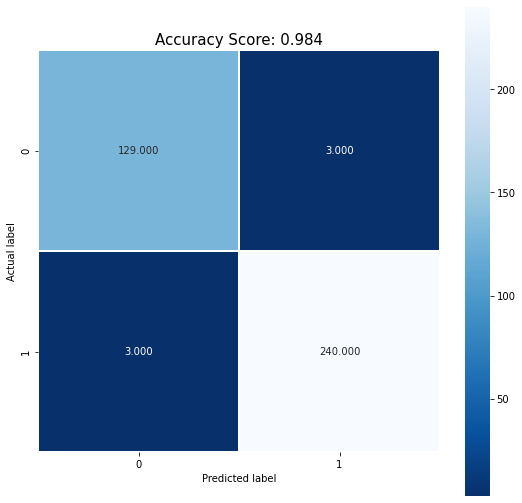

In [142]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_test)
prediction = list(map(round, yhat))

# confusion matrix

from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_test, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_test, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [143]:
# Taux de faux billets non détectés
3/132*100

2.272727272727273

## Résultat sur le train set

In [144]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_train)
prediction = list(map(round, yhat))

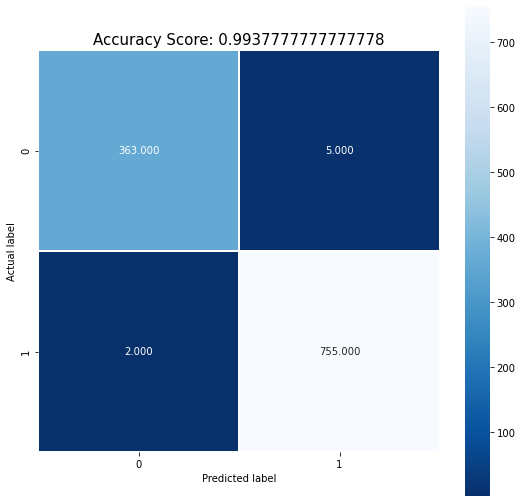

In [145]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_train, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_train, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [146]:
# Taux de faux billets non détectés
5/368*100

1.358695652173913

## Résultat sur tout le dataset

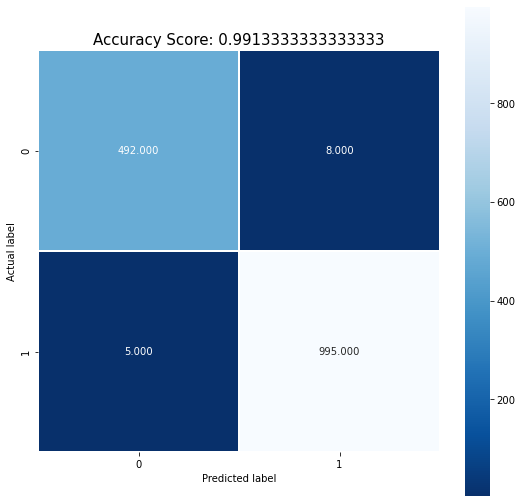

In [147]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_billets2)
prediction = list(map(round, yhat))

# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_billets2, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_billets2, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [148]:
# Taux de faux billets non détectés
8/500*100

1.6

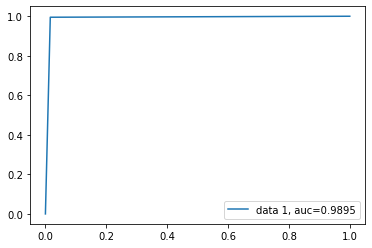

In [149]:
# ROC Curve
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = billets2['is_genuine']
y_probas = prediction

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Régression logistique avec statsmodels
- height_left enlevé du modèle : p value à 0.132

## Suppression colonne height_left

In [150]:
x_train = x_train.drop(columns='height_left')
x_test = x_test.drop(columns='height_left')
x_billets2 = x_billets2.drop(columns='height_left')

## Calcul de la régression logistique

In [151]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, x_train).fit()

Optimization terminated successfully.
         Current function value: 0.025504
         Iterations 12


In [152]:
# printing the summary table
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1125
Model:                          Logit   Df Residuals:                     1121
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Jul 2022   Pseudo R-squ.:                  0.9597
Time:                        08:38:37   Log-Likelihood:                -28.692
converged:                       True   LL-Null:                       -711.13
Covariance Type:            nonrobust   LLR p-value:                1.234e-295
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
height_right    -5.2194      0.907     -5.758      0.000      -6.996      -3.443
length           5.4439      0.890      6.119      0.000       3.700       7.188
margin_low      -6.5137      1.200     -5.42

## Résultat sur le test set

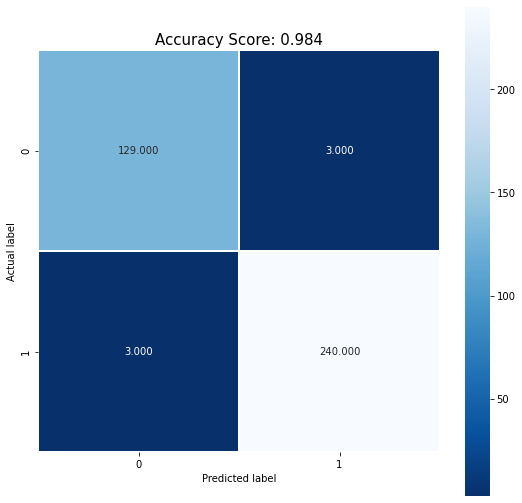

In [153]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_test)
prediction = list(map(round, yhat))

# confusion matrix

from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_test, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_test, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [154]:
# Taux de faux billets non détectés
3/132*100

2.272727272727273

## Résultat sur le train set

In [155]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_train)
prediction = list(map(round, yhat))

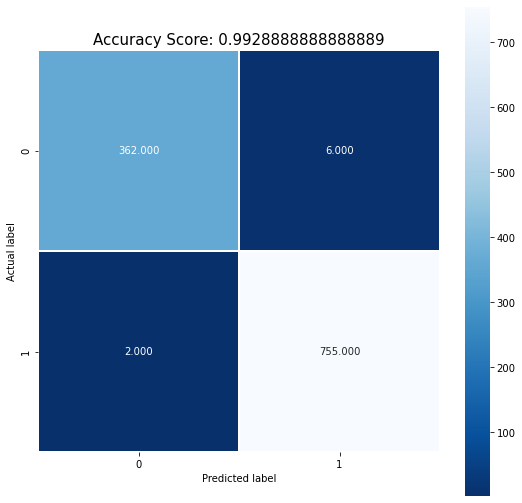

In [156]:
# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_train, prediction) 

# accuracy score of the model
accuracy_score = accuracy_score(y_train, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [157]:
# Taux de faux billets non détectés
6/368*100

1.6304347826086956

## Résultat sur tout le dataset

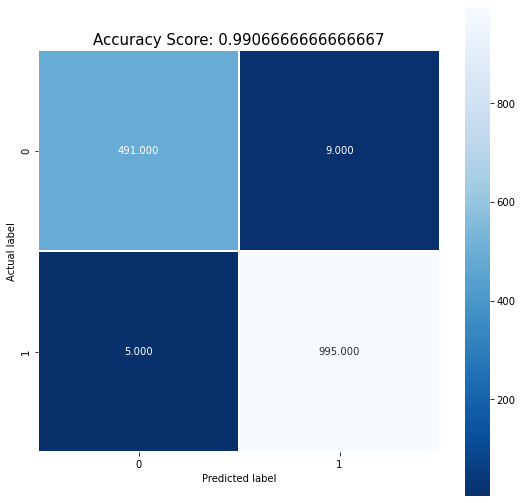

In [158]:
# performing predictions on the test datdaset
yhat = log_reg.predict(x_billets2)
prediction = list(map(round, yhat))

# confusion matrix
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)
cm = confusion_matrix(y_billets2, prediction) 


# accuracy score of the model
accuracy_score = accuracy_score(y_billets2, prediction)

# Matrice de confusion - Heatmap
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score)
plt.title(all_sample_title, size = 15);

In [159]:
# Taux de faux billets non détectés
9/500*100

1.7999999999999998

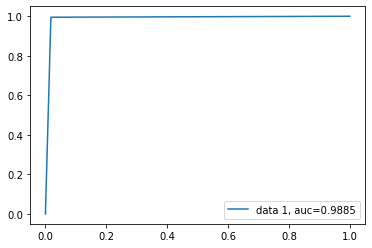

In [160]:
# ROC Curve
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = billets2['is_genuine']
y_probas = prediction

fpr, tpr, _ = metrics.roc_curve(y_true,  y_probas)
auc = metrics.roc_auc_score(y_true, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Conclusion sur les modèles
Critère : Taux de faux négatifs sur le dataset en entier

- K Means = 1.80%
- Régression logistique avec toutes les variables + constante = 1.60 %
- Régression logistique avec toutes les variables - constante = 1.80%
- Régression logistique - variable diagonal - constante = 1.60%
- Régression logistique - variables diagonal et height_left - constante = 1.80%

2 modèles arrivent à 1.60% de faux négatifs, mais le modèle sans la variable diagonal et sans la constante a des résultats sur les P-Values rendant la prédiction plus robuste (sans la constante avec une P-value de 0.481 et la variable diagonal avec une P-value de 0.561).

## Prédiction autres billets

In [163]:
def prediction (dataset):
    billets_test = pd.read_csv(dataset)
    # Splitting Data into Training and Test Sets (test_set = 25%)
    x_train, x_test, y_train, y_test = train_test_split(billets2[['height_left','height_right',\
                                                             'length','margin_low','margin_up']],\
                                                    billets2['is_genuine'], test_size=0.25, random_state=0)
    # Séparation sur tout le daset variables explicatives - variable expliquée
    x_billets2 = billets2[['height_left','height_right','length','margin_low','margin_up']]
    y_billets2 = billets2['is_genuine']
    # building the model and fitting the data
    log_reg = sm.Logit(y_train, x_train).fit()
    # Extraction des variables explicatives
    billets_a_tester = billets_test[['height_left','height_right','length','margin_low','margin_up']]
    # performing predictions
    yhat = log_reg.predict(billets_a_tester)
    prediction = list(map(round, yhat))
    # Ajout de la prédiction au dataset à tester
    pd.options.mode.chained_assignment = None
    billets_test['prediction'] = prediction
    # remplacement prédiction par valeur textuelle
    billets_test = billets_test.replace(1,'vrai billet')
    billets_test = billets_test.replace(0,'faux billet')
    # Sortie des résultats
    print(billets_test)

# Test du modèle sur d'autres datasets

In [165]:
prediction('billets_production.csv')

Optimization terminated successfully.
         Current function value: 0.024450
         Iterations 12
   diagonal  height_left  height_right  margin_low  margin_up    length   id  \
0 171.76000    104.01000     103.54000     5.21000    3.30000 111.42000  A_1   
1 171.87000    104.17000     104.13000     6.00000    3.31000 112.09000  A_2   
2 172.00000    104.58000     104.29000     4.99000    3.39000 111.57000  A_3   
3 172.49000    104.55000     104.34000     4.44000    3.03000 113.20000  A_4   
4 171.65000    103.63000     103.56000     3.77000    3.16000 113.33000  A_5   

    prediction  
0  faux billet  
1  faux billet  
2  faux billet  
3  vrai billet  
4  vrai billet  


In [164]:
prediction('billets_test.csv')

Optimization terminated successfully.
         Current function value: 0.024450
         Iterations 12
   diagonal  height_left  height_right  margin_low  margin_up    length   id  \
0 172.09000    103.95000     103.73000     4.39000    3.09000 113.19000  B_1   
1 171.52000    104.17000     104.03000     5.27000    3.16000 111.82000  B_2   
2 171.78000    103.80000     103.75000     3.81000    3.24000 113.39000  B_3   
3 172.02000    104.08000     103.99000     5.57000    3.30000 111.10000  B_4   
4 171.79000    104.34000     104.37000     5.00000    3.07000 111.87000  B_5   

    prediction  
0  vrai billet  
1  faux billet  
2  vrai billet  
3  faux billet  
4  faux billet  
